In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def read_txt_file(file_path):
    with open(file_path) as f:
        text = f.read()
    return text

def split_chapter(Split_text="CHAPTER", text=""):
    chapters = text.split(Split_text)
    return chapters

def word_count(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    freq_dist = FreqDist(words)
    return freq_dist

def draw_word_cloud(freq_dist,name): 
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
    plt.figure(figsize=(10, 5))
    # set the title of the wordcloud
    plt.title(name)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

def get_chapter_word_count(chapters):
    chapter_word_count = []
    for chapter in chapters:
        freq_dist = word_count(chapter)
        chapter_word_count.append(len(freq_dist))
    return chapter_word_count

def get_chapter_freq_dist(chapters):
    chapter_freq_dist = []
    for chapter in chapters:
        freq_dist = word_count(chapter)
        chapter_freq_dist.append(freq_dist)
    return chapter_freq_dist

def draw_chapter_wordcloud(freq_dists):
    for i, freq_dist in enumerate(freq_dists):
        draw_word_cloud(freq_dist, f"Chapter {i+1}")


# Extract Person Entities and relationships From Text

In [2]:
import spacy
import nltk
from nltk import pos_tag, word_tokenize
from nltk.chunk import ne_chunk
from nltk.tree import Tree
from nltk import word_tokenize, pos_tag
from nltk.parse.corenlp import CoreNLPDependencyParser

# Initialize the dependency parser using the CoreNLP server
dependency_parser = CoreNLPDependencyParser(url='http://localhost:9000')

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Download NLTK resources
nltk.download("punkt")
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("averaged_perceptron_tagger")

def extract_entities(text):
    """
    Extracts named entities labeled as "PERSON" from the input text.
    Uses NLTK's named entity chunking.
    """
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    chunked = ne_chunk(pos_tags, binary=False)
    entities = []

    for subtree in chunked:
        # If the chunk is a named entity of type PERSON, add it to the entity list
        if isinstance(subtree, Tree) and subtree.label() == "PERSON":
            entity = " ".join([leaf[0] for leaf in subtree.leaves()])
            entities.append(entity)
    return entities

def entities_filter(entities, threshold=1):
    """
    Filters entities based on their frequency in the text.
    Only entities appearing more than the threshold are returned.
    """
    freq = FreqDist(entities)
    return [k for k, v in freq.items() if v > threshold]

def get_person_relationships(text):
    """
    Finds relationships between consecutive "PERSON" entities in the text
    by identifying verbs, prepositions, and adjectives between entities.
    """
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    entities = extract_entities(text)
    relationships = []

    # Iterate over pairs of consecutive entities
    for i in range(len(entities) - 1):
        entity1 = entities[i]
        entity2 = entities[i + 1]
        relation = []

        # Identify words between the two entities
        start = words.index(entity1.split()[0]) + len(entity1.split())
        end = words.index(entity2.split()[0])
        for j in range(start, end):
            word, tag = pos_tags[j]

            # Collect verbs, prepositions, adjectives, and adverbs as part of the relationship
            if tag.startswith("VB") or tag in ["IN", "JJ", "RB"]:
                relation.append(word)

        # If a relationship phrase is identified, add it to the list
        if relation:
            relationships.append((entity1, " ".join(relation), entity2))

    # Remove duplicates
    relationships = list(set(relationships))
    return relationships

def get_entity_relationships(text):
    """
    Extracts relationships between entities by identifying verbs between them.
    Specifically looks for verbs between two "PERSON" entities.
    """
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    entities = extract_entities(text)
    relationships = []

    for i in range(len(entities) - 1):
        entity1 = entities[i]
        entity2 = entities[i + 1]
        relation = None

        # Look for verbs in the span between the two entities
        start = words.index(entity1.split()[0]) + len(entity1.split())
        end = words.index(entity2.split()[0])
        for j in range(start, end):
            if pos_tags[j][1].startswith("VB"):
                relation = pos_tags[j][0]
                break

        if relation:
            relationships.append((entity1, relation, entity2))

    # Remove duplicate relationships
    relationships = list(set(relationships))
    return relationships

def count_sentences(text):
    """
    Counts the number of sentences in the text using spaCy's sentence tokenizer.
    """
    doc = nlp(text)
    return len(list(doc.sents))

def split_sentences(text):
    """
    Splits text into individual sentences using spaCy's sentence tokenizer.
    """
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def output_chapters(chapters, output_path="HP-1"):
    """
    Outputs each chapter into a separate text file within a specified directory.
    """
    for i, chapter in enumerate(chapters):
        with open(f"{output_path}/chapter_{i+1}.txt", "w") as f:
            f.write(chapter)
    print("Chapters have been written to files.")

def book_preprocess(file_path, output_path="HP-1"):
    """
    Preprocesses a book by reading, splitting into chapters, and saving each chapter to a separate file.
    """
    text = read_txt_file(file_path)
    chapters = split_chapter(Split_text="CHAPTER", text=text)
    chapters = chapters[1:]  # Skip the preamble
    print(f"There are {len(chapters)} Chapters in this book")
    output_chapters(chapters, output_path)
    return chapters

def output_relationships(relationships, output_path="relationships.csv"):
    """
    Outputs relationships to a CSV file with specified columns.
    """
    df = pd.DataFrame(relationships, columns=["Character", "Relationship Type", "Target Character"])
    df.to_csv(output_path, index=False)
    print("Relationships have been written to a CSV file.")

def test_1():
    """
    Test function for get_person_relationships.
    Example usage for finding relationships in a sample sentence.
    """
    text = "Harry met Hermione, Hermione knows Ron, and Harry likes Ron."
    entity_list = ["Harry", "Hermione", "Ron"]
    print(get_person_relationships(text))

# Sample test call for verification
# test_1()

[nltk_data] Downloading package punkt to /Users/allenygy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/allenygy/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/allenygy/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allenygy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


There are 17 Chapters in this book
Chapters have been written to files.
Summary text has 291 sentences
There are 28 entities in the summary
There are 78 relationships in the summary
Relationships have been written to a CSV file.


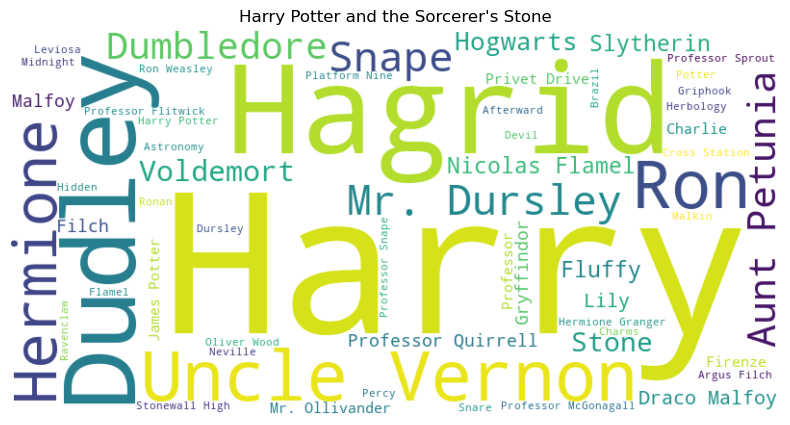

In [5]:

def main():
    books_file_path ="books/Harry_Potter_and_the_Sorcerer's_Stone.txt"
    chapters = book_preprocess(books_file_path)
    
    # read summary file
    summary_file_path ="summary/HP.txt"
    summary_text = read_txt_file(summary_file_path)

    # get sentence count
    sentence_count=count_sentences(summary_text)
    print(f'Summary text has {sentence_count} sentences')  

    # Extract entities from the summary
    entities = extract_entities(summary_text)
    freq = FreqDist(entities)
    draw_word_cloud(freq, "Harry Potter and the Sorcerer's Stone")
    entity_list=entities_filter(entities,threshold=1)
    print(f"There are {len(entity_list)} entities in the summary")
    # print(f"Entities: {entity_list}")

    relationships = get_entity_relationships(summary_text)
    print(f"There are {len(relationships)} relationships in the summary")
    # Output relationships to a csv file
    output_relationships(relationships)
main()

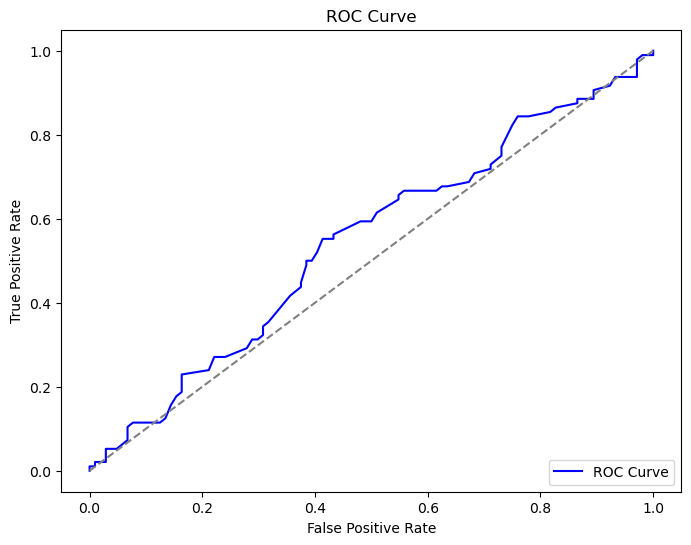

Random Forest Accuracy: 0.565, Random Forest ROC-AUC: 0.5442708333333334


/opt/homebrew/Caskroom/miniforge/base/envs/BDA/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:26:06] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.475, XGBoost ROC-AUC: 0.4767628205128206
Gradient Boosting Accuracy: 0.555, Gradient Boosting ROC-AUC: 0.5572916666666667


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier


def ctr_prediction_RandomForest(data):
    """
    Function to predict Click-Through Rate (CTR) using a machine learning model.
    
    Parameters:
    - data: pandas DataFrame, where the last column is 'CTR' (target variable).
    
    Returns:
    - model: trained model.
    - accuracy: model's accuracy score.
    - auc: ROC-AUC score.
    - y_pred: Predicted CTR values.
    """
    # Preprocessing steps (same as before)
    if data.isnull().sum().any():
        data = data.dropna()

    categorical_cols = ['user_location', 'ad_type']  # Example categorical columns
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    X = data.drop(columns=['CTR'])  # Features
    y = data['CTR']  # Target variable: CTR (0 = No Click, 1 = Click)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model (e.g., Random Forest, Logistic Regression, etc.)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Step 9: Plotting Model Performance (Optional)
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return model, accuracy, auc, y_pred


def ctr_prediction_xgboost(data):
    """
    Function to predict Click-Through Rate (CTR) using XGBoost Classifier.
    
    Parameters:
    - data: pandas DataFrame, where the last column is 'CTR' (target variable).
    
    Returns:
    - model: trained XGBoost model.
    - accuracy: model's accuracy score.
    - auc: ROC-AUC score.
    - y_pred: Predicted CTR values.
    """
    # Preprocessing steps (same as before)
    if data.isnull().sum().any():
        data = data.dropna()

    categorical_cols = ['user_location', 'ad_type']
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    X = data.drop(columns=['CTR'])  # Features
    y = data['CTR']  # Target variable: CTR (0 = No Click, 1 = Click)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the XGBoost Classifier
    model = xgb.XGBClassifier(use_label_encoder=False, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    return model, accuracy, auc, y_pred


def ctr_prediction_gradient_boosting(data):
    """
    Function to predict Click-Through Rate (CTR) using Gradient Boosting Classifier.
    
    Parameters:
    - data: pandas DataFrame, where the last column is 'CTR' (target variable).
    
    Returns:
    - model: trained Gradient Boosting model.
    - accuracy: model's accuracy score.
    - auc: ROC-AUC score.
    - y_pred: Predicted CTR values.
    """
    # Preprocessing steps (same as before)
    if data.isnull().sum().any():
        data = data.dropna()

    categorical_cols = ['user_location', 'ad_type']
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    X = data.drop(columns=['CTR'])  # Features
    y = data['CTR']  # Target variable: CTR (0 = No Click, 1 = Click)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Gradient Boosting Classifier
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    return model, accuracy, auc, y_pred


# Example usage
if __name__ == "__main__":
    # Generate simulated dataset
    np.random.seed(42)
    data = {
        'user_age': np.random.randint(18, 65, 1000),
        'user_location': np.random.choice(['US', 'Europe', 'Asia'], 1000),
        'ad_type': np.random.choice(['text', 'image', 'video'], 1000),
        'plot_interest': np.random.rand(1000),  # Numerical feature: Interest level in the plot
        'CTR': np.random.choice([0, 1], 1000)  # Target variable: Clicked (1) or Not Clicked (0)
    }
    df = pd.DataFrame(data)

    # Call the CTR prediction function
    model, accuracy, auc, y_pred = ctr_prediction_RandomForest(df)
    print(f"Random Forest Accuracy: {accuracy}, Random Forest ROC-AUC: {auc}")

    # Call the CTR prediction function using XGBoost
    model_xgb, accuracy_xgb, auc_xgb, y_pred_xgb = ctr_prediction_xgboost(df)
    print(f"XGBoost Accuracy: {accuracy_xgb}, XGBoost ROC-AUC: {auc_xgb}")

    # Call the CTR prediction function using Gradient Boosting
    model_gb, accuracy_gb, auc_gb, y_pred_gb = ctr_prediction_gradient_boosting(df)
    print(f"Gradient Boosting Accuracy: {accuracy_gb}, Gradient Boosting ROC-AUC: {auc_gb}")


In [ ]:
def read_txt_file(file_path):
    with open(file_path) as f:
        text = f.read()
    return text

def split_sentences(text):
    """
    Splits text into individual sentences using spaCy's sentence tokenizer.
    """
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

# read summary file
summary_file_path ="./summary/HP.txt"
summary_text = read_txt_file(summary_file_path)

sentences = split_sentences(summary_text)
print(len(sentences))

In [18]:
from transformers import pipeline

# 加载 Hugging Face 上的情感分析模型
classifier = pipeline("sentiment-analysis")

def rate_story_segment(segment):
    result = classifier(segment)
    
    sentiment = result[0]['label']  # 'POSITIVE' 或 'NEGATIVE'
    score = result[0]['score']  # 情感的置信度分数
    
    # 你可以在这里调整评分的逻辑
    if sentiment == 'POSITIVE':
        rating = 70 + (score * 30)  
    else:
        rating = 30 + (score * 40)  

    return round(rating, 1)/100

# segment = "Dumbledore arrives at Privet Drive. Dumbledore uses a device to turn off streetlights..."

ratings = []

result=[]

for sentence in sentences:
    rating = rate_story_segment(sentence)
    result.append((sentence, rating))


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [19]:
result_df = pd.DataFrame(result, columns=["Sentence", "Rating"])

# sort by rating
result_df = result_df.sort_values(by="Rating", ascending=False)


In [20]:
result_df.to_csv("summary/sentiment_analysis.csv", index=False)

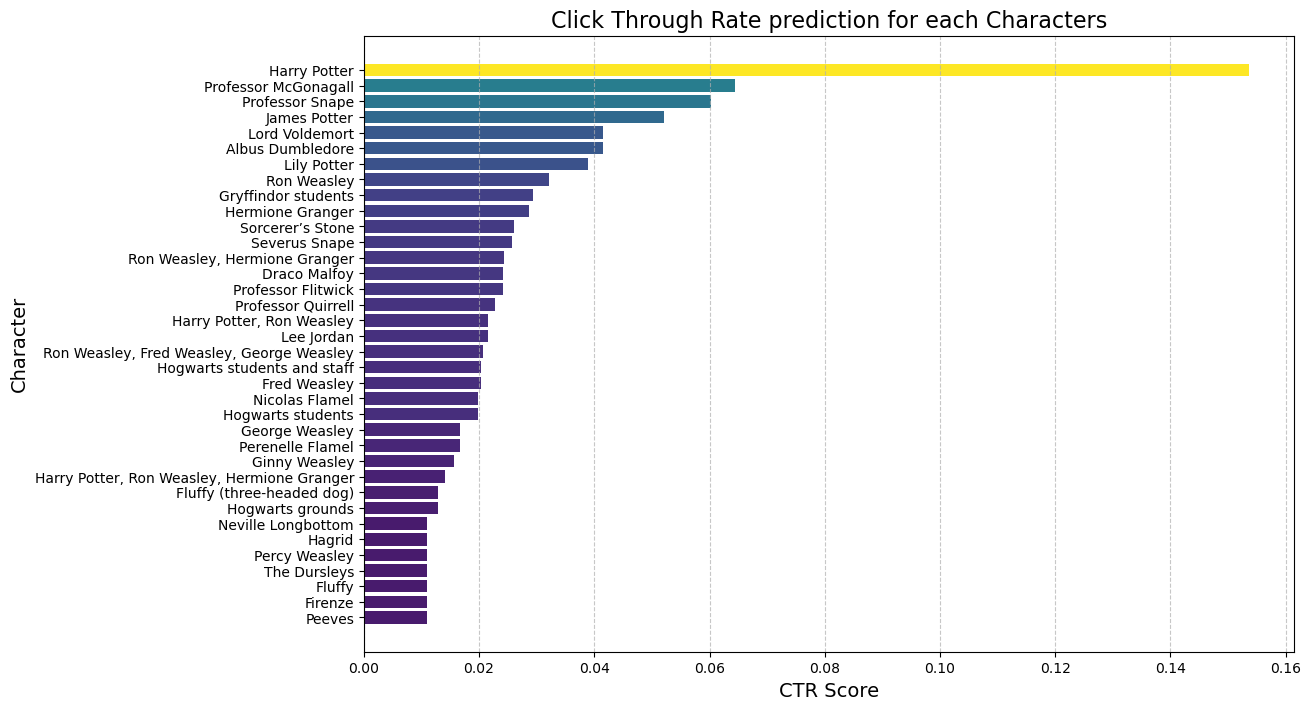

In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load character relationships data
character_relationships_df = pd.read_csv("summary/character_relationships.csv")

# Initialize a directed graph
G = nx.DiGraph()

# Add edges to the graph from the DataFrame
for _, row in character_relationships_df.iterrows():
    character_a = row["Character"]
    character_b = row["Target Character"]
    G.add_edge(character_a, character_b)

# Apply PageRank algorithm to compute importance scores for each character
pagerank_scores = nx.pagerank(G)

# Convert the results to a DataFrame for easier viewing and display
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=["Character", "PageRank Score"])
pagerank_df = pagerank_df.sort_values(by="PageRank Score", ascending=False)

# Plotting with enhanced aesthetics
plt.figure(figsize=(12, 8))
plt.barh(pagerank_df["Character"], pagerank_df["PageRank Score"], color=plt.cm.viridis(pagerank_df["PageRank Score"]/max(pagerank_df["PageRank Score"])))

plt.gca().invert_yaxis()  # Highest rank on top
plt.xlabel("CTR Score", fontsize=14)
plt.ylabel("Character", fontsize=14)
plt.title("Click Through Rate prediction for each Characters", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()